In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('mistral7B_L40S.csv', delimiter=';')
df = df[df['Time (ms)'] > 0.1]  # Filter out invalid entries

In [3]:
import ast

import matplotlib.pyplot as plt

def fn_context_value(val, fn):
    if pd.isna(val):
        return 0
    seq = val
    # parse string representations like "[14]" -> list
    if isinstance(val, str):
        try:
            seq = ast.literal_eval(val)
        except Exception:
            # fallback: try to parse single int in string
            try:
                return int(val)
            except Exception:
                return 0
    # now seq can be int/float or iterable
    total = 0
    for item in seq:
        total += fn(item)
    return total



### Decode Only

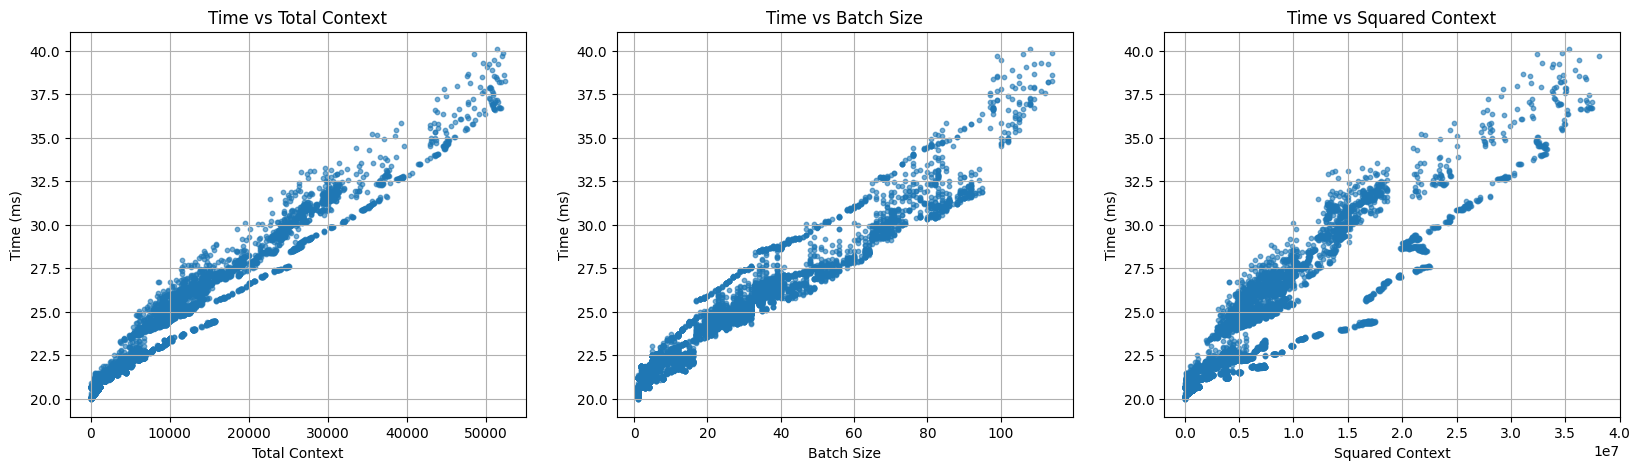

In [4]:
# compute context aggregate features by passing the value into fn_context_value via a lambda
df['context_sum'] = df['Context'].apply(lambda v: fn_context_value(v, lambda item: item))
df['context_len'] = df['Context'].apply(lambda v: fn_context_value(v, lambda item: 1))
df['context_sq'] = df['Context'].apply(lambda v: fn_context_value(v, lambda item: item * item))
# , df['Context'].apply(lambda x: len(ast.literal_eval(x)) if pd.notna(x) and x != "[]" else 0), df['Context'].apply(sq_context_value)

df_plot = df[df['Prefill'] == "[]"]
fig, axes = plt.subplots(1,3, figsize=(20,5))
axes[0].scatter(df_plot['context_sum'], df_plot['Time (ms)'], alpha=0.6, s=10)
axes[0].set_xlabel('Total Context')
axes[0].set_ylabel('Time (ms)')
axes[0].set_title('Time vs Total Context')
axes[0].grid(True)

axes[1].scatter(df_plot['context_len'], df_plot['Time (ms)'], alpha=0.6, s=10)
axes[1].set_xlabel('Batch Size')
axes[1].set_ylabel('Time (ms)')
axes[1].set_title('Time vs Batch Size')
axes[1].grid(True)

axes[2].scatter(df_plot['context_sq'], df_plot['Time (ms)'], alpha=0.6, s=10)
axes[2].set_xlabel('Squared Context')
axes[2].set_ylabel('Time (ms)')
axes[2].set_title('Time vs Squared Context')
axes[2].grid(True)

plt.show()

Training and Evaluating Models...
- Linear Regression (Simple): R-squared = 0.9809, Average Relative Difference = 0.0154
- Decision Tree Regressor: R-squared = 0.9910, Average Relative Difference = 0.0043
- Random Forest Regressor (Ensemble): R-squared = 0.9946, Average Relative Difference = 0.0036
- XGBoost Regressor: R-squared = 0.9938, Average Relative Difference = 0.0044
- GBR: R-squared = 0.9932, Average Relative Difference = 0.0046
- MLPRegressor_Optimized: R-squared = 0.9910, Average Relative Difference = 0.0086


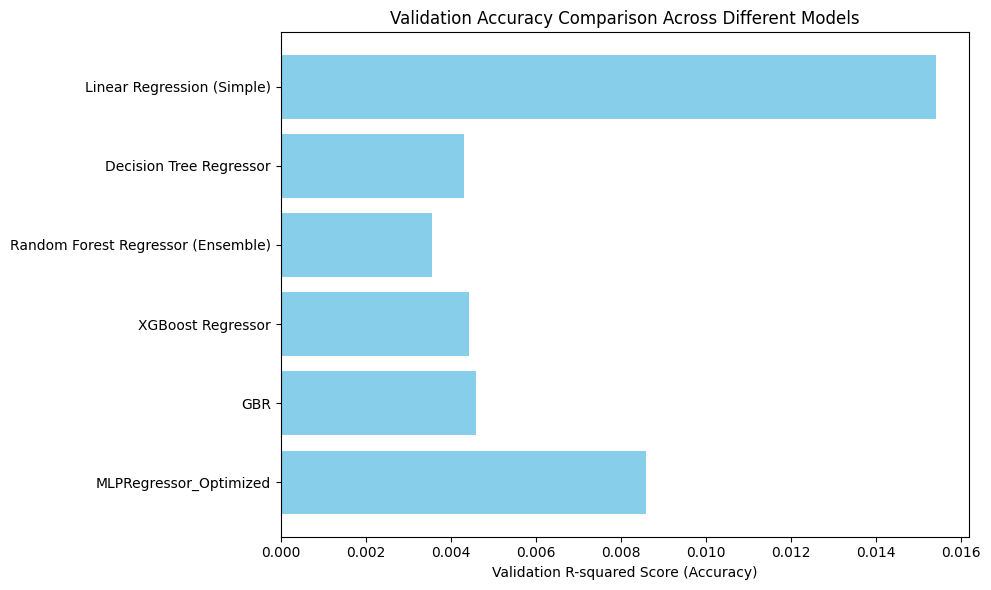

In [5]:
#import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import xgboost as xgb 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# --- 1. Data Preparation (Using a placeholder DataFrame) ---
# Replace this with your actual df
# data = {
#     'B': np.random.rand(100) * 10,
#     'L': np.random.rand(100) * 5,
#     'T': (np.random.rand(100) * 5) + (np.random.rand(100) * 2) # T = f(B, L) + noise
# }
# df = pd.DataFrame(data)

# Define Features (X) and Target (y)
X = df_plot[['context_sum', 'context_len', 'context_sq']]# , 'context_sq'
y = df_plot['Time (ms)']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. Model Selection & Training ---
models = {
    "Linear Regression (Simple)": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    # "Support Vector Regressor (SVR)": SVR(kernel='linear'),
    "Random Forest Regressor (Ensemble)": RandomForestRegressor(n_estimators=100, random_state=42),
    # "Multi-layer Perceptron (Complex)": MLPRegressor(hidden_layer_sizes=(150, 150), max_iter=5000, random_state=42),
    "XGBoost Regressor": xgb.XGBRegressor(
            n_estimators=1000, 
            learning_rate=0.1, 
            max_depth=3, 
            random_state=42,
            n_jobs=-1 # Use all available cores for parallel processing
        ),
    "GBR" : GradientBoostingRegressor(
    n_estimators=1000,      # Number of boosting stages
    learning_rate=0.1,     # Shrinkage factor for each tree
    max_depth=3,
    random_state=42),
    # Try this improved MLP definition
    "MLPRegressor_Optimized": MLPRegressor(
    hidden_layer_sizes=(100, 50, 25), # Added more layers/neurons
    max_iter=500,                    # Significantly increased iterations
    activation='relu',               # ReLU is generally preferred over 'tanh' or 'logistic'
    solver='adam',
    learning_rate_init=0.01,         # Slightly faster learning rate
    early_stopping=True,             # Stop early if validation score stalls
    n_iter_no_change=20,             # Wait longer for an improvement before stopping
    random_state=42)
}

results = {}

print("Training and Evaluating Models...")
for name, model in models.items():
    # Train the model
    if name == "MLPRegressor_Optimized":
        # Use a pipeline with scaling for MLP
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('mlp', model)
        ])
        pipeline.fit(X_train, y_train)
        model = pipeline  # Replace model with the pipeline for prediction

    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Evaluate using R-squared (common for regression)
    score = r2_score(y_val, y_pred)
    avg_diff = np.mean(np.abs(1 - (y_pred / y_val)))
    results[name] = (score, avg_diff)
    print(f"- {name}: R-squared = {score:.4f}, Average Relative Difference = {avg_diff:.4f}")

# --- 3. & 4. Evaluation and Visualization ---
model_names = list(results.keys())
validation_scores = [score for _, score in results.values()]

plt.figure(figsize=(10, 6))
plt.barh(model_names, validation_scores, color='skyblue')
plt.xlabel('Validation R-squared Score (Accuracy)')
plt.title('Validation Accuracy Comparison Across Different Models')
# plt.xlim(min(validation_scores) * 0.95, 1.0) # Adjust x-limit for better visual
plt.gca().invert_yaxis() # Highest score at the top
plt.tight_layout()
plt.show()

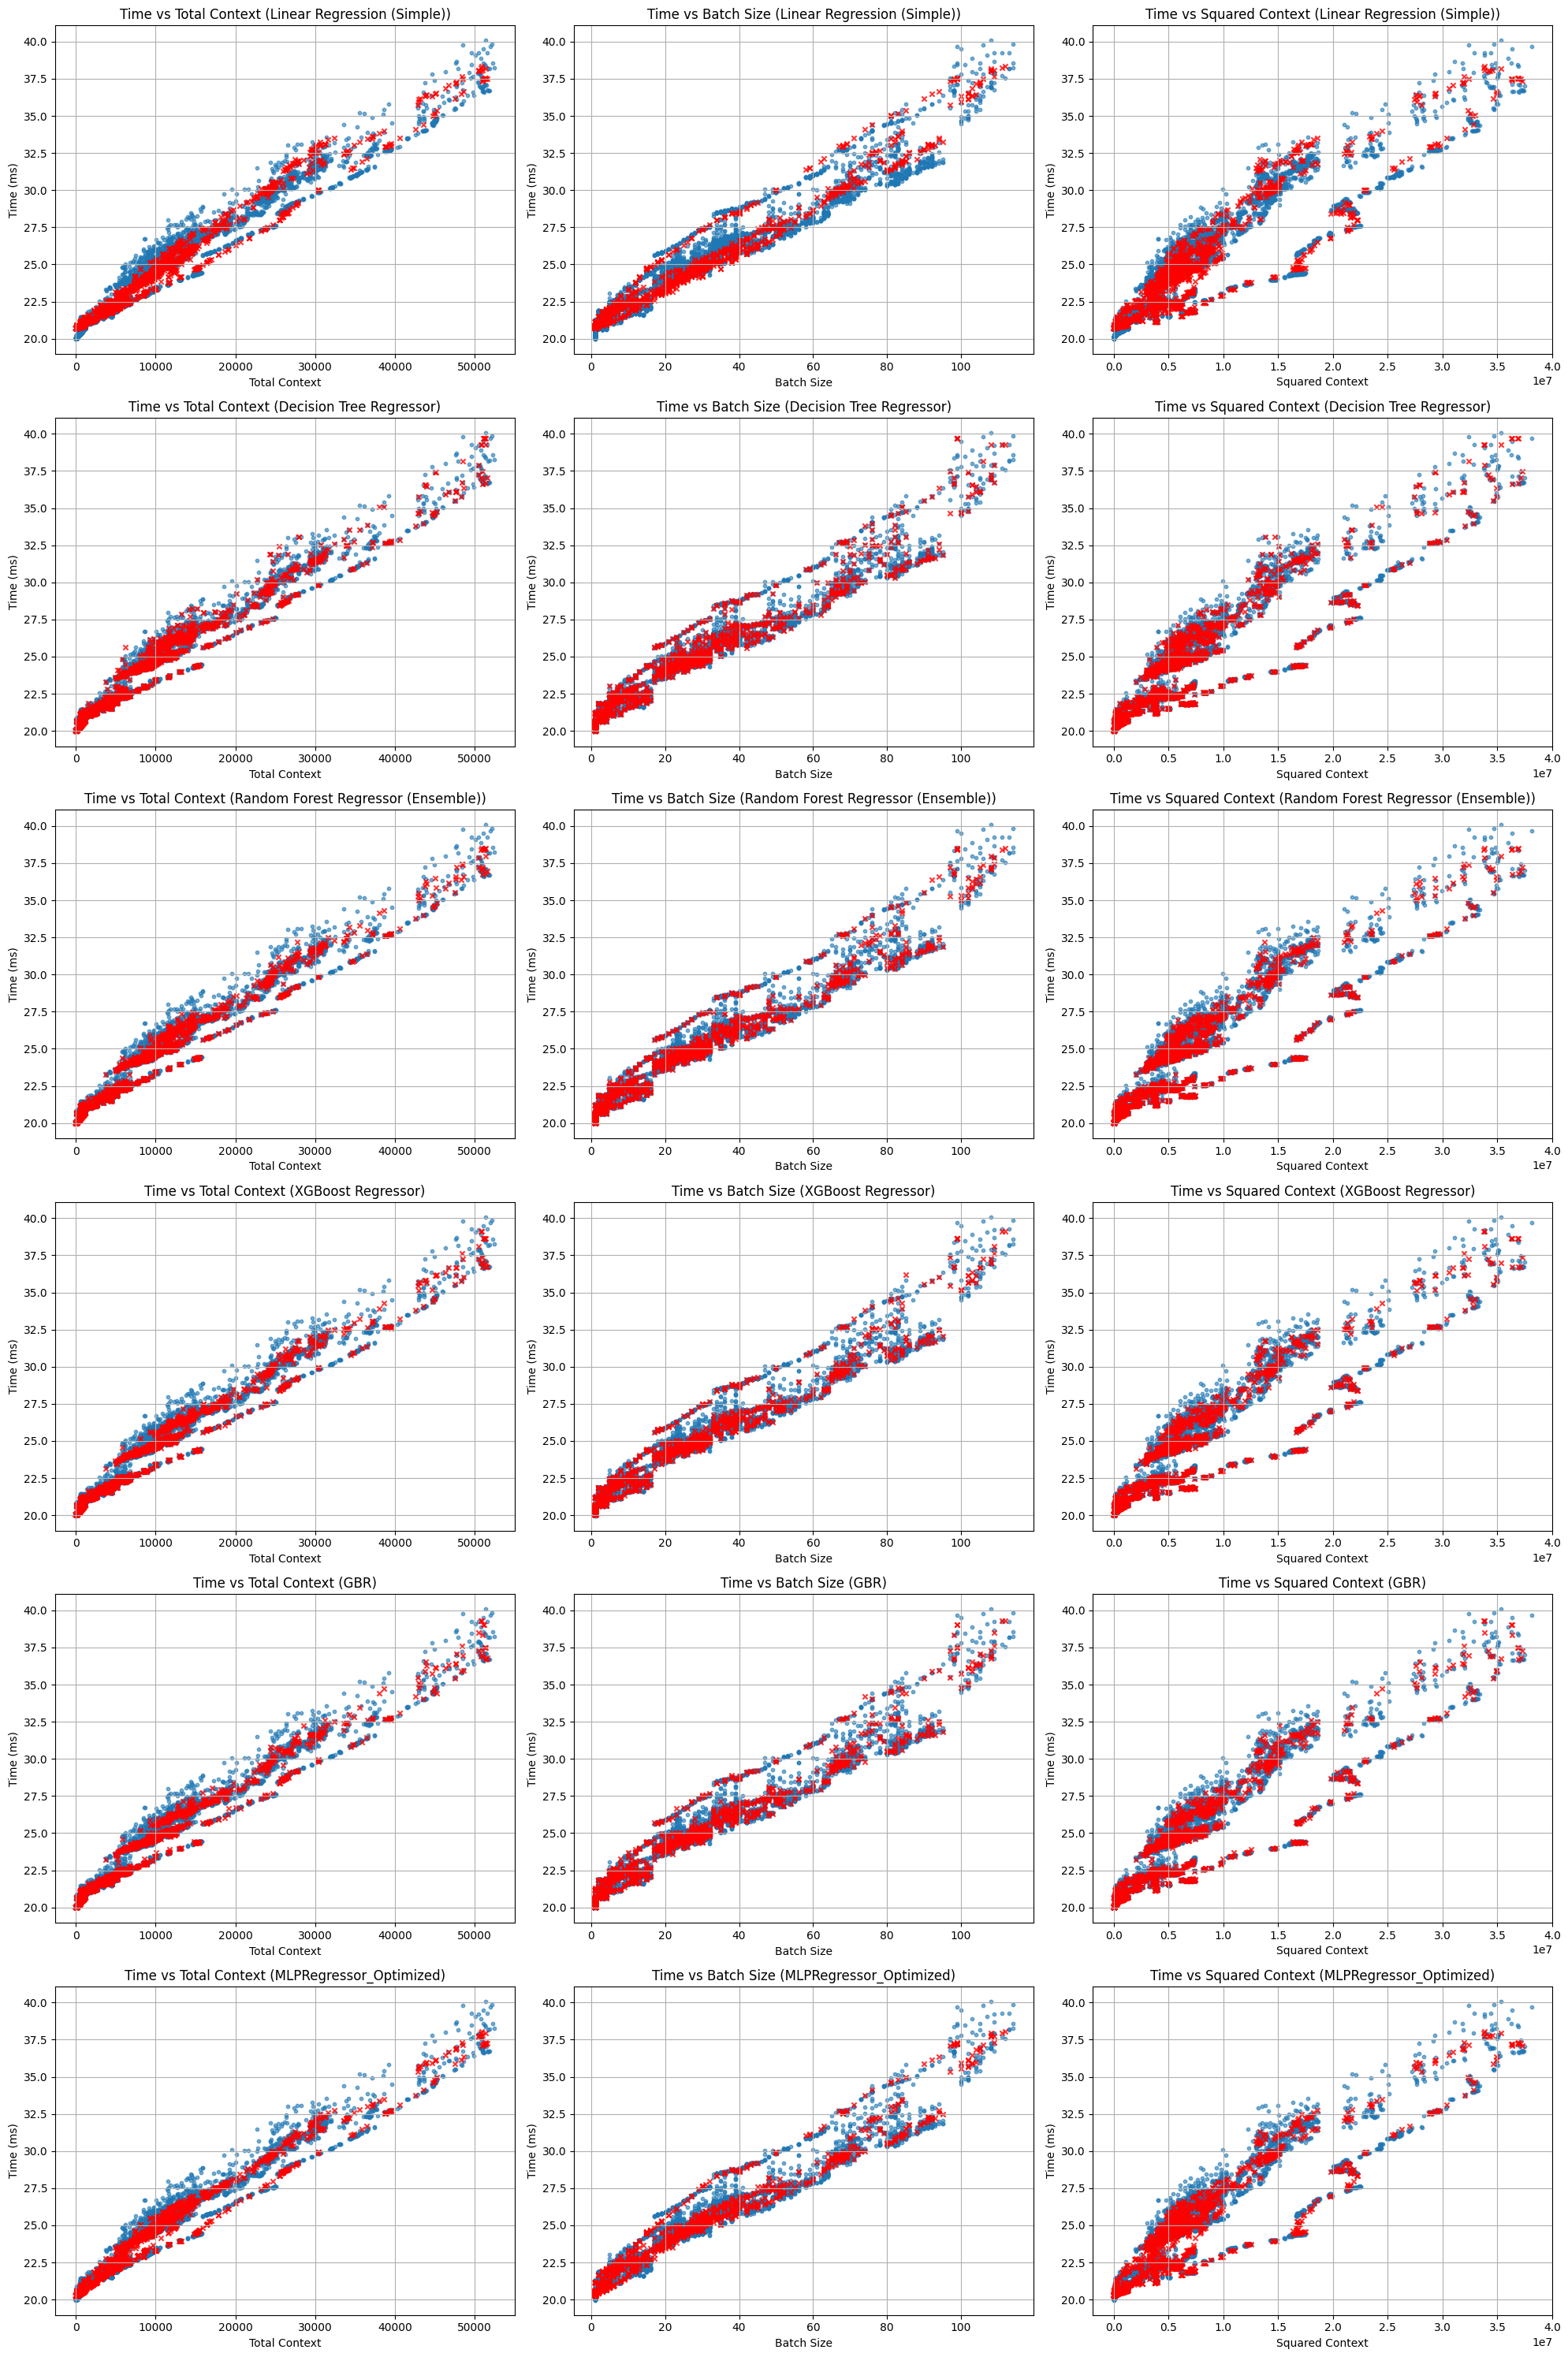

In [6]:
fig, axes = plt.subplots(len(models),3, figsize=(20,5*len(models)))

for i, (name, model) in enumerate(models.items()):
    # Make predictions on the validation set
    if name == "MLPRegressor_Optimized":
        # Use a pipeline with scaling for MLP
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('mlp', model)
        ])
        pipeline.fit(X_train, y_train)
        model = pipeline  # Replace model with the pipeline for prediction
    y_pred = model.predict(X_val)

    axes[i, 0].scatter(df_plot['context_sum'], df_plot['Time (ms)'], alpha=0.6, s=10, marker='o')
    axes[i, 0].scatter(X_val['context_sum'], y_pred, color='red', alpha=0.8, s=20, marker='x') 
    axes[i, 0].set_xlabel('Total Context')
    axes[i, 0].set_ylabel('Time (ms)')
    axes[i, 0].set_title(f'Time vs Total Context ({name})')
    axes[i, 0].grid(True)

    axes[i, 1].scatter(df_plot['context_len'], df_plot['Time (ms)'], alpha=0.6, s=10)
    axes[i, 1].scatter(X_val['context_len'], y_pred, color='red', alpha=0.8, s=20, marker='x') 
    axes[i, 1].set_xlabel('Batch Size')
    axes[i, 1].set_ylabel('Time (ms)')
    axes[i, 1].set_title(f'Time vs Batch Size ({name})')
    axes[i, 1].grid(True)

    axes[i, 2].scatter(df_plot['context_sq'], df_plot['Time (ms)'], alpha=0.6, s=10)
    axes[i, 2].scatter(X_val['context_sq'], y_pred, color='red', alpha=0.8, s=20, marker='x') 
    axes[i, 2].set_xlabel('Squared Context')
    axes[i, 2].set_ylabel('Time (ms)')
    axes[i, 2].set_title(f'Time vs Squared Context ({name})')
    axes[i, 2].grid(True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_979593/2867053884.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_list, vert=False, patch_artist=True, labels=model_names)


<Figure size 1000x600 with 0 Axes>

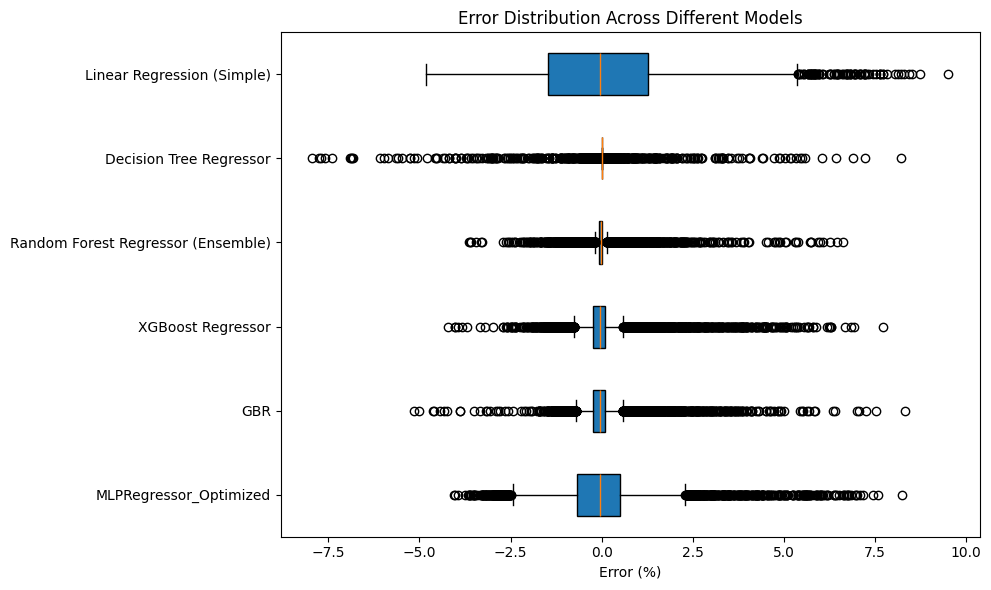

In [7]:
plt.figure(figsize=(10, 6))

error = {}
for i, (name, model) in enumerate(models.items()):
    # Make predictions on the validation set
    if name == "MLPRegressor_Optimized":
        # Use a pipeline with scaling for MLP
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('mlp', model)
        ])
        pipeline.fit(X_train, y_train)
        model = pipeline  # Replace model with the pipeline for prediction
    y_all_pred = model.predict(X)
    error[name] = (1 - y_all_pred/y)*100

model_names = list(error.keys())
error_list = list(error.values())

plt.figure(figsize=(10, 6))
plt.boxplot(error_list, vert=False, patch_artist=True, labels=model_names)
plt.xlabel('Error (%)')
plt.title('Error Distribution Across Different Models')
plt.gca().invert_yaxis() # Highest score at the top
plt.tight_layout()
plt.show()    

In [8]:
import joblib

# Save the trained Random Forest model using joblib
joblib.dump(models['Random Forest Regressor (Ensemble)'], 'random_forest_model.joblib')

['random_forest_model.joblib']

In [9]:
#
rf_loaded = joblib.load('random_forest_model.joblib') # Load saved Random Forest model#